## Setup

In [1]:
import json
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

## Quantitative Analysis

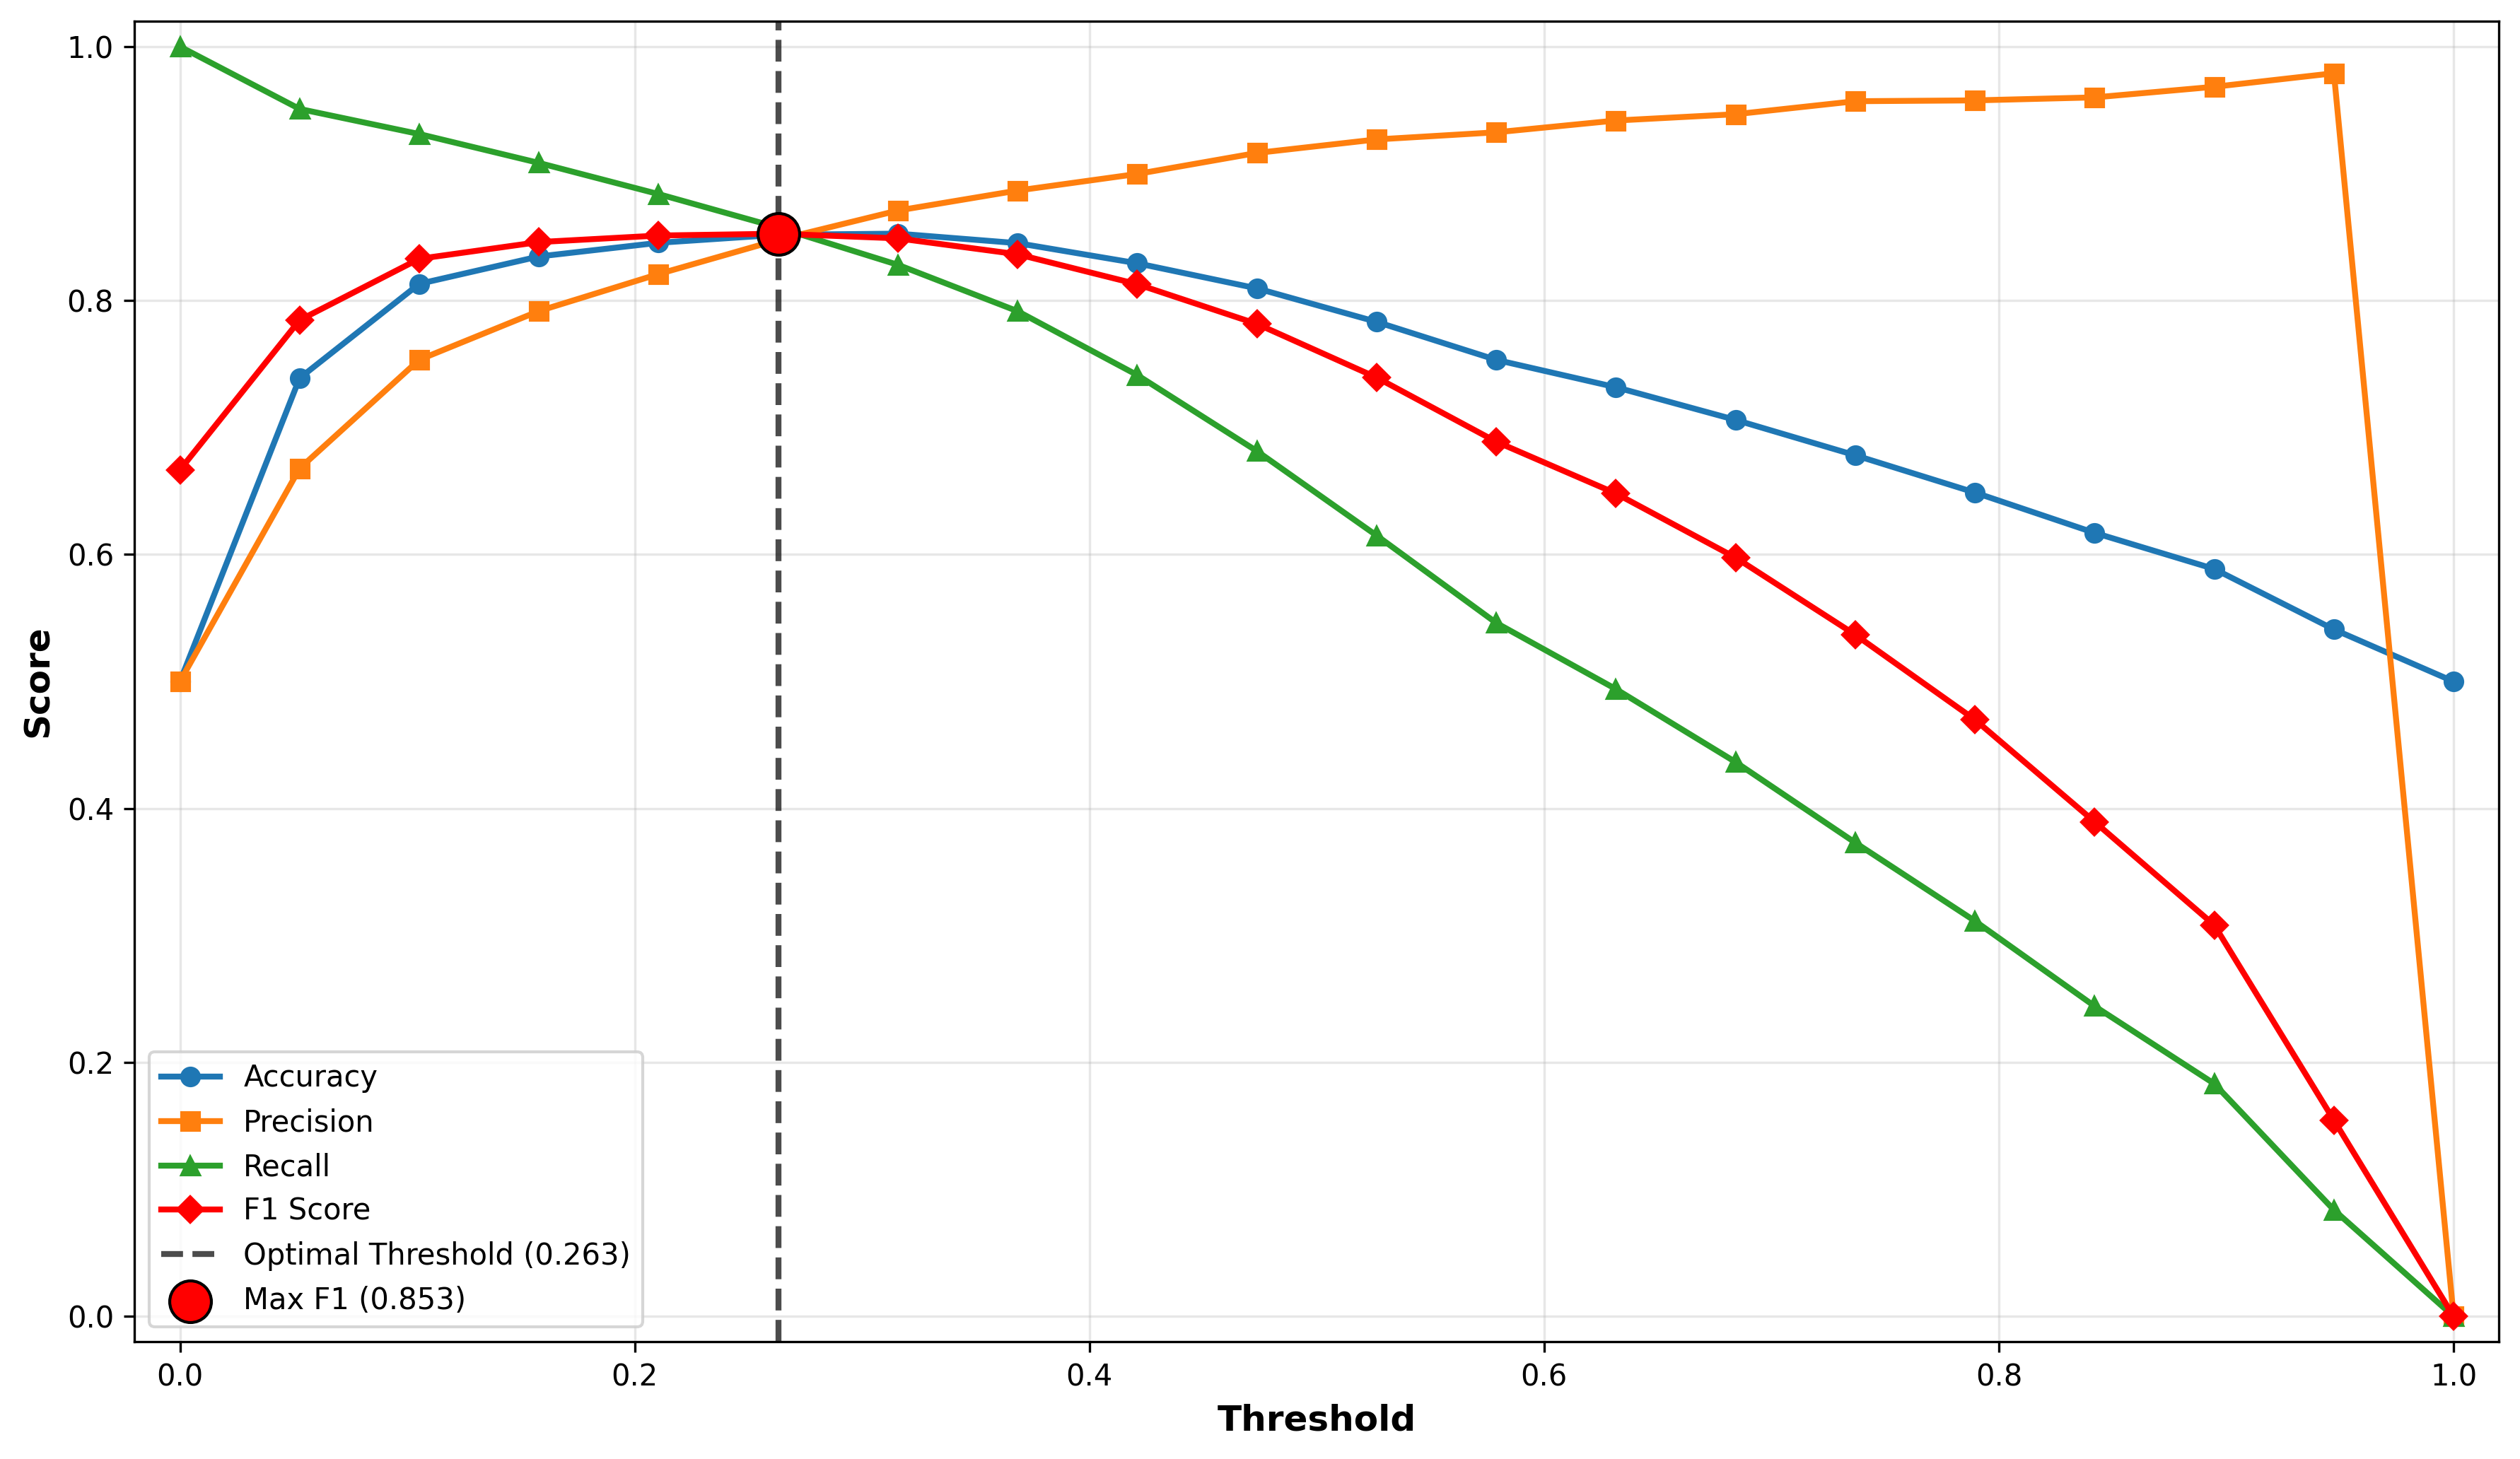

In [3]:
threshold_gridsearch_path = 'roberta-large_threshold_analysis_plot.png'

Image.open(threshold_gridsearch_path)

In [4]:
roberta_metrics_path = 'roberta-large_optimal_threshold_predictions.json'
with open(roberta_metrics_path, 'r') as f:
    roberta_data = json.load(f)   

In [5]:
roberta_data.keys()

dict_keys(['optimal_threshold', 'predictions', 'ground_truth', 'metrics'])

In [6]:
roberta_metrics = roberta_data['metrics']

In [7]:
roberta_metrics

{'accuracy': 0.8517964071856288,
 'precision': 0.8478389579632919,
 'recall': 0.8574850299401198,
 'f1': 0.8526347127121167}

In [8]:
pd.DataFrame(pd.Series(roberta_metrics)).T

,accuracy,precision,recall,f1
0,0.851796,0.847839,0.857485,0.852635


In [9]:
thresholds = np.linspace(0, 1, 20)
thresholds

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

## Decision Framework

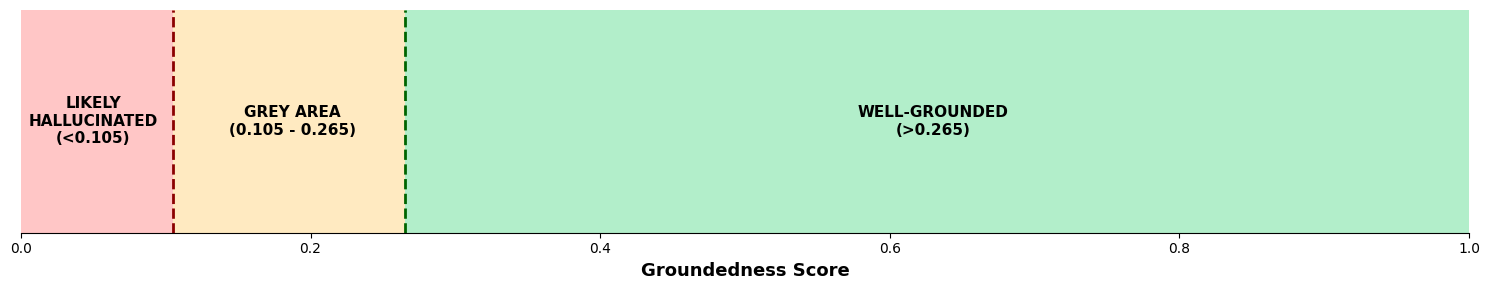

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 3))

ax.barh(0, 0.105, left=0, height=1, color='#ff4444', alpha=0.3, label='Likely Hallucinated')
ax.barh(0, 0.160, left=0.105, height=1, color='#ffbb33', alpha=0.3, label='Grey Area')
ax.barh(0, 0.735, left=0.265, height=1, color='#00c851', alpha=0.3, label='Well-Grounded')

ax.axvline(0.105, color='darkred', linestyle='--', linewidth=2)
ax.axvline(0.265, color='darkgreen', linestyle='--', linewidth=2)

ax.text(0.05, 0, 'LIKELY\nHALLUCINATED\n(<0.105)', 
        ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(0.1875, 0, 'GREY AREA\n(0.105 - 0.265)', 
        ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(0.63, 0, 'WELL-GROUNDED\n(>0.265)', 
        ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Groundedness Score', fontsize=13, fontweight='bold')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Qualitative Analysis

In [10]:
with open("hallucination_eval_dataset.json", "r") as f:
    eval_data = json.load(f)
questions = []
excerpts = []
ground_truth = []
claims= []
answers = []
for doc in eval_data:
    question = doc['question']
    excerpt_paragraph = doc['excerpt_paragraph']
    true_answer = doc['true_answer']
    wrong_answer = doc['wrong_answer']
    
    if excerpt_paragraph.strip() and true_answer.strip() and wrong_answer.strip() and question.strip():
        questions.extend([question]*2)
        excerpts.extend([excerpt_paragraph]*2)
        answers.extend([true_answer]*2)
        claims.append(true_answer)
        claims.append(wrong_answer)
        ground_truth.append(True)
        ground_truth.append(False)

In [11]:
eval_data_df = pd.DataFrame({'question':questions, 'excerpt':excerpts, 'claim':claims,'answer':answers})
eval_data_df.head()

,question,excerpt,claim,answer
0,What spatial resolution was achieved by the nano-DESI technique when imaging relatively flat tissues?,"More recently, a nano- DESI technique was developed that was able to achieve 10 µm spatial resolution when imaging relatively flat tissues (brain and lung). 53 This was achieved by adjusting the widths of the capillaries within the DESI probe and implementing a shear force probe to ensure droplets were within 1 µm of the tissue. 53",10 µm,10 µm
1,What spatial resolution was achieved by the nano-DESI technique when imaging relatively flat tissues?,"More recently, a nano- DESI technique was developed that was able to achieve 10 µm spatial resolution when imaging relatively flat tissues (brain and lung). 53 This was achieved by adjusting the widths of the capillaries within the DESI probe and implementing a shear force probe to ensure droplets were within 1 µm of the tissue. 53",5 µm,10 µm
2,What is the false-positive ratio for the given data?,"Figure 1 (a) (b) (c) (d) 0 ND ND 0.1 0.3 0.5 0.65 1 20 20 0.2 0 0.1 40 60 80 100Detection efficiency (%) False-positive ratio w 0 0.1 0.3 0.5 0.65 1 2 w NS *** *** Cell #1 Cell #2 Cell #3 G25 G25/BF G25 G25/BF G25 G25/BF Aggregates: (-) (+) (+) (+) (+) 0 1 3 1 3 0 1 1 1 1 I II III IV V Naggs/cell: Naggs-posi cell: .CC-BY-NC-ND 4.0 International licensemade available under a (which was not certified by peer review) is the author/funder, who has granted bioRxiv a license to display the preprint in perpetuity. It is The copyright holder for this preprintthis version posted April 11, 2025. ; https://doi.org/10.1101/2025.04.04.647339doi: bioRxiv preprint",w 0 0.1 0.3 0.5 0.65 1 2,w 0 0.1 0.3 0.5 0.65 1 2
3,What is the false-positive ratio for the given data?,"Figure 1 (a) (b) (c) (d) 0 ND ND 0.1 0.3 0.5 0.65 1 20 20 0.2 0 0.1 40 60 80 100Detection efficiency (%) False-positive ratio w 0 0.1 0.3 0.5 0.65 1 2 w NS *** *** Cell #1 Cell #2 Cell #3 G25 G25/BF G25 G25/BF G25 G25/BF Aggregates: (-) (+) (+) (+) (+) 0 1 3 1 3 0 1 1 1 1 I II III IV V Naggs/cell: Naggs-posi cell: .CC-BY-NC-ND 4.0 International licensemade available under a (which was not certified by peer review) is the author/funder, who has granted bioRxiv a license to display the preprint in perpetuity. It is The copyright holder for this preprintthis version posted April 11, 2025. ; https://doi.org/10.1101/2025.04.04.647339doi: bioRxiv preprint",w 0.2 0.4 0.6 0.8 1.0 1.5,w 0 0.1 0.3 0.5 0.65 1 2
4,What is the primary application for such techniques in the computer vision realm?,"1. Introduction and Background Establishing dense correspondence or mapping between two images is a fundamental problem in both computer vision and medical imaging analysis. Numerous methods have been proposed that are primarily based on pioneering works in [2, 6]. Motion analysis through estimating the op- tical ﬂow has been the primary application for such tech- niques in the computer vision realm, whereas image reg- istration has been the driving application from the medical image analysis side. The underlying approach has always been similar: minimization of a two-term energy functional balancing off an image distance metric with some constraint on the underlying correspondence map. Calculus of varia- tions enables the derivation of an iterative solution scheme for the problem of minimizing the energy functional. The condition of minimal energy is reached in a state when two conceptual forces acting against each other are in an equi- librium. One of these forces pulls points in one of the im- ages towards a position that decreases the distance between the two images. The second force, determined by the regu- larizer, can be thought of as a constraint on the pixel move- ments which counteracts the effects of the former force. Im- age distance metrics have evolved from linear opticﬂow constraints to non-linear sum of squared differences on im- age intensities or gradients, andﬁnally to information theo- retic distances/simil

In [12]:
predictions = roberta_data['predictions']
ground_truth = [1 if idx%2==0 else 0 for idx in range(len(predictions))]
truth_vs_prediction=  pd.DataFrame({"predictions": predictions, "ground_truth":ground_truth })
truth_vs_prediction.head()

,predictions,ground_truth
0,1,1
1,0,0
2,1,1
3,0,0
4,1,1


In [13]:
question_to_eval_mapping = [[i,i] for i in range(len(eval_data))]
question_to_eval_mapping = [i for j in question_to_eval_mapping for i in j]

In [14]:
question_to_eval_mapping=  pd.DataFrame({"question_to_eval_mapping": question_to_eval_mapping })
question_to_eval_mapping.head()

,question_to_eval_mapping
0,0
1,0
2,1
3,1
4,2


In [15]:
false_negatives = (truth_vs_prediction['predictions'] == 0) & (truth_vs_prediction['ground_truth'] == 1)
false_negatives.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [16]:
false_positives = (truth_vs_prediction['predictions']==1) & (truth_vs_prediction['ground_truth']==0)
false_positives.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [31]:
eval_data_df[false_negatives].tail()

,question,excerpt,claim,answer
3196,"What is the year of publication of the article by Gao Y, Wu C, Chen X, Ma L, Zhang X, Chen J, Liao X and Liu M?","Gao Y, Wu C, Chen X, Ma L, Zhang X, Chen J, Liao X and Liu M (2 022) PET/CT molecular imaging in the era of immune-checkpoint inhibitors therapy. Front Immunol 13:1049043.",2022,2022
3222,What is the name of the technique for evaluating empirical entropy of a distribution presented in this chapter?,"Ch apt er /3 Empir i cal En tro p y Manipula t ion an d St oc h ast i c Gradien t De scen t Thi s c h apt er pre s en t san o v el t ec hnique for ev alua t in ga n dm anipula t in gt h e empir ical en tro p y of a di str ibu t ion/, calle d EMMA/. Th et h eory of en tro p ym anipula t ion p lays a cr it ical ro le in t h er e s to f t hi s t h esis a n d forms t h e algor it hmic core in all of t h ea p p lica t ions/.",EMMA,EMMA
3230,What is the correlation between any two adjacent time points in the first case of the repeated measures ANOVA model?,"In the first case of the repeated measures ANOVA model, we assumed ρ = 0.7 in the AR(1) structure, treatment means were 0.2, 0.15, 0.3 and 0.5 at the four time points, respectively, and the attrition rate was 0.10 between any two adjacent time points.",0.7,0.7
3302,What was Patient 2's Apgar score at 1 minute?,"Patient 2: A twenty-year-old woman with a generalized seizure disor­ der received valproic acid (1750 mg daily) throughout her pregnancy; she had no seizures with that regimen. Labor was induced at 38 weeks because of absent fetal movements. She gave birth to baby A-B, a boy weighing 2100 gm.The Apgar score was 6,8 and 8 at 1,5 and 10 minutes respectively.",6,6
3326,"What publication year does the reference with authors Syed MUS, Khan Z, Zulfiqar A, Basham MA, Abdul Haseeb H, Azizullah S, Ismail H, Elbahnasawy M, Nadeem Z and Karimi S have?","EXPERIMENTAL AND THERAPEUTIC MEDICINE 29: 117, 2025 9 33. Syed MUS, Khan Z, Zulfiqar A, Basham MA, Abdul Haseeb H, Azizullah S, Ismail H, Elbahnasawy M, Nadeem Z and Karimi S: Electrocardiographic abnormalities in patients with spinal cord injury with deranged lipid profile. Cureus 13: e18246, 2021.",2021,2021


In [36]:
eval_data_df[false_positives].head()

,question,excerpt,claim,answer
13,What could be removed by aligning each spectrum to the mean spectrum and re-calibrating the m/z positions via the internal calibrants?,"Page 7 of 14 Föll et al. Clinical Proteomics (2022) 19:8 with the tool name, tool version and all set parameters. For each of the first five analysis steps, Galaxy workflows were built and published to enable re-running the same analysis in a standardized and automated way. The pre- processing workflow is depicted as an example in Fig. 1b. Quality control and preprocessing The acquired data showed pronounced intensity batch effects and m/z shifts, which could be removed through careful adjustment of the preprocessing steps. Key to observe and overcome these technical issues was the usage of internal calibrants [17] together with the Gal - axy ‘MSI qualitycontrol’ tool, which generated more than 30 different descriptive plots. Both TMAs showed systematically increasing m/z values for the internal cali - brants during the course of the measurement (Fig. 2a). This suggests that the TOF tube of the near-antique mass spectrometer, which was not built to acquire tens of thousands of spectra in a row, heated up during the measurement. These m/z shifts could be removed by aligning each spectrum to the mean spectrum and re- calibrating the m/z positions via the internal calibrants (Fig. 2b). Intensity batch effects were observed between the two measurements with higher intensities in TMA2 (Fig. 2a). As the baseline was already removed during data acquisi - tion, TIC normalization could not be performed on the raw data as suggested by Deininger et al. [31]. Instead we were able to reduce the batch effects (Fig. 2b) by per- forming TIC normalization after peak picking and con - taminant removal as suggested by Fonville [32]. Classification of tumor and stroma spectra In several cancers, tumor cells are intermingled or sur - rounded by connective tissue, the so-called tumor stroma, which is part of the tumor microenvironment. To Fig. 2 Data properties accessed by the ‘MSI qualitycontrol’ tool. a Mass and intensity shifts before pre‑processing. b Mass and intensity shifts could be reduced through careful adjustment of pre‑processing steps and parameters",baseline shifts,m/z shifts
57,What equation defines Ψ(y)?,Sparse eigenvalue problem•Quadratic form•Rayleigh-Ritz quotientOptimal embedding given by bottomd+1 eigenvectors.•SolutionDiscard bottom eigenvector [1 1 … 1].Other eigenvectors satisfy constraints. Ψ(y)=Ψijij∑yi•yj() with Ψ=(I−W)T(I−W),Ψ(y)=Ψijij∑yi•yj() with Ψ=(I−W)T(I−W)T,Ψ(y)=Ψijij∑yi•yj()
67,"What distribution does Ti|Hi follow when Hi is 1 for i = 1,...,m?","Because of the connection made in Section 3, the q-value is useful in both Bayesian and frequentist settings. It gives the scientist a hypothesis testing error measure for each observed statistic with respect to the pFDR. Again, assume that (Ti,Hi) are i.i.d. random variables, Ti|Hi ∼ (1 − Hi) · F0 + Hi · F1,a n d Hi ∼ Bernoulli(1 − π0) for i = 1,...,m . We introduce the q-value by ﬁrst showing an example. EXAMPLE [Testing the mean of a N(θ, 1) random variable]. Suppose we perform m hypothesis tests of θ = 0v e r s u sθ = 2f o rmN ( θ ,1) random variables T1,...,T m. Speciﬁcally, (Ti,Hi) are i.i.d. random variables with Ti|Hi ∼ (1 − Hi) · N(0,1) + Hi · N(2,1). Given we observe the random variables to be T1 = t1,...,T m = tm,t h ep-value of Ti = ti can be calculated as p-value(ti) = Pr(T ≥ ti|H = 0) = Pr ( N(0,1) ≥ ti ) . In words, p-value(ti) gives the Type I error rate if we reject any statistic as extreme or more extreme than ti. By Theorem 1 the pFDR, if we reject any statistic as extreme or more extreme than ti, among all m hypotheses is pFDR({T ≥ ti}) = π0 Pr(T ≥ ti|H = 0) π0 Pr(T ≥ ti|H = 0) + π1 Pr(T ≥ ti|H = 1) = π0 Pr(N(0,1) ≥ ti) π0 Pr(N(0,1) ≥ ti) + π1 Pr(N(2,1) ≥ ti) = Pr(H = 0|T ≥ ti). (4.1) From the last line, it can be seen that pFDR ({T ≥ ti}) = Pr(H = 0|T ≥ ti) is a natural Bayesian 

### Conclusion

**Note**
- To make the evaluation challenging, the correct and wrong answers are similar - while one is grounded, the other isn't

**False Negatives**

Inferences:
- The model is more false negative prone when:
    - The answers are numbers
    - The reference text is too long
    - The reference text has formatting issues

Solutions:
- Formatting issues could be addressed with more stringent processing
- Instances of longer references could be addressed by shortening the chunk size and/ or limiting the complexity of queries. For eg. queries that require synthesis from multiple sources would have to be segmented across multiple requests. This would be at the cost of latency and convience however. Perhaps this is a limitation we accept.
- To improve the quality of responses with numbers, training with such a data would help. Or this is a limitation we accept.

**False Positives**

Inferences:
- The model is more false positive prone when:
    - The answers are numbers
    - The wrong answer is highly similar to the correct answer

Solutions:
- To improve the quality of responses with numbers and similar answers, training with such a data would help. Or this is a limitation we accept.